In [5]:
%run /Users/denis/Documents/Projects/scripts/init.ipy
os.chdir(os.getcwd().replace('/pipeline', ''));

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [6]:
from sklearn.decomposition import PCA

In [7]:
count_dataframe = pd.read_table('./s2-expression.dir/kallisto/kallisto-counts.txt', index_col='gene_symbol')
count_dataframe.head()

sample_10_1  sample_10_2  sample_10_3  sample_11_1  sample_11_2  \
gene_symbol                                                                    
A1BG                 190          190          156          178          171   
A1CF                  17           10           25           19           15   
A2M                 2891         3021         5963         2489         3302   
A2ML1                 34           12           26           28           21   
A3GALT2                0            0            1            0            1   

             sample_11_3  sample_12_1  sample_12_2  sample_12_3  sample_13_1  \
gene_symbol                                                                    
A1BG                 187          183          183          177          231   
A1CF                  17           31           14           34           17   
A2M                 8057         2012         3218        19624         3510   
A2ML1                 23           30           13           33           24   
A3GALT2                0            1            0            2            2   

                ...      sample_7_2  sample_7_3  sample_7_4  sample_8_1  \
gene_symbol     ...                                                       
A1BG            ...             219         173         156         211   
A1CF            ...               8          17          17          16   
A2M             ...            2942        7502       12873        4365   
A2ML1           ...              20          18          10          44   
A3GALT2         ...               1           0           0           0   

             sample_8_2  sample_8_3  sample_8_4  sample_9_1  sample_9_2  \
gene_symbol                                                               
A1BG                186         153         219         233         205   
A1CF                  8          17          27          24          27   
A2M                2936        6728       26207        3652        2474   
A2ML1                 4           9          23          18          43   
A3GALT2               0           0           0           1           1   

             sample_9_3  
gene_symbol              
A1BG                173  
A1CF                 21  
A2M                6945  
A2ML1                19  
A3GALT2               0  

[5 rows x 115 columns]

In [8]:
metadata_dataframe = pd.read_table('./rawdata/metadata/dubois-metadata.txt', index_col='Sample')
metadata_dataframe.head()

Diff Condition             Description
Sample                                           
sample_5_1  148   Control  Control cardiomyocytes
sample_5_2  149   Control  Control cardiomyocytes
sample_5_3  150   Control  Control cardiomyocytes
sample_6_1  148   + delta      PPAR delta agonist
sample_6_2  149   + delta      PPAR delta agonist

## 1. PCA

In [44]:
def plot_pca(group_name, conditions):
    
    # Subset
    metadata_dataframe_subset = metadata_dataframe.query('Condition in {}'.format(conditions))
    count_dataframe_subset = count_dataframe[metadata_dataframe_subset.index]

    # Filter and normalize
    logcpm_dataframe_subset = np.log10((count_dataframe_subset/count_dataframe_subset.sum())*10**6+1)
    gene_subset = logcpm_dataframe_subset.var(axis=1).sort_values(ascending=False).index[:1000]
    zscore_dataframe = logcpm_dataframe_subset.loc[gene_subset].T.apply(ss.zscore).T

    # Run PCA
    pca=PCA(n_components=3)
    pca.fit(zscore_dataframe)
    var_explained = ['PC'+str((i+1))+' ('+str(round(e*100, 1))+'% var. explained)' for i, e in enumerate(pca.explained_variance_ratio_)]

    # Merge
    pca_dataframe = pd.DataFrame(pca.components_, columns=zscore_dataframe.columns, index=['PC{}'.format(x+1) for x in range(len(pca.components_))]).T
    plot_dataframe = pca_dataframe.merge(metadata_dataframe, left_index=True, right_index=True)

    # Sample titles
    sample_titles = ['{index}<br>Condition: {Condition}<br>Diff: {Diff}'.format(**rowData, **locals()) for index, rowData in plot_dataframe.iterrows()]

    # Loop through color by
    for color_by in ['Diff', 'Condition']:

        # 3D Scatter Plot
        unique_categories = plot_dataframe[color_by].unique()
        data = []
        for i, category in enumerate(unique_categories):
            category_color = colors[i]
            category_indices = np.array([i for i, sample_category in enumerate(plot_dataframe[color_by]) if sample_category == category])
            # Create new trace
            trace = go.Scatter3d(x=np.array(plot_dataframe['PC1'])[category_indices],
                                 y=np.array(plot_dataframe['PC2'])[category_indices],
                                 z=np.array(plot_dataframe['PC3'])[category_indices],
                                 mode='markers',
                                 hoverinfo='text',
                                 text=[sample_titles[x] for x in category_indices],
                                 name = category,
                                 marker=dict(size=15, color=category_color))

            # Append trace to data list
            data.append(trace)

        layout = go.Layout(title='<b>{group_name} PCA Analysis</b><br><i>Colored by {color_by}</i>'.format(**locals()), hovermode='closest', margin=go.Margin(l=0,r=0,b=0,t=50), width=900,
            scene=dict(xaxis=dict(title=var_explained[0]), yaxis=dict(title=var_explained[1]),zaxis=dict(title=var_explained[2])))
        fig = go.Figure(data=data, layout=layout)

        iplot(fig)

In [46]:
# Read
with open('pipeline/notebooks/dubois_groups.json', 'r') as openfile:
    groups = json.load(openfile)

# Loop
for group_name, conditions in groups.items():
    plot_pca(group_name, conditions)

## 2. Heatmap

In [124]:
def plot_heatmap(group_name, conditions):
    
    # Subset
    metadata_dataframe_subset = metadata_dataframe.query('Condition in {}'.format(conditions)).drop('Description', axis=1)
    count_dataframe_subset = count_dataframe[metadata_dataframe_subset.index]

    # Filter and normalize
    logcpm_dataframe_subset = np.log10((count_dataframe_subset/count_dataframe_subset.sum())*10**6+1)
    gene_subset = logcpm_dataframe_subset.var(axis=1).sort_values(ascending=False).index[:1000]
    heatmap_dataframe = logcpm_dataframe_subset.loc[gene_subset]

#     sns.clustermap(heatmap_dataframe, z_score=0, cmap='RdBu_r');
    display(Markdown('### '+group_name))
    %R -h 500 -w 800 -i heatmap_dataframe,metadata_dataframe_subset,group_name plot_pheatmap(heatmap_dataframe, metadata_dataframe_subset)

In [125]:
%%R
plot_pheatmap <- function(heatmap_dataframe, metadata_dataframe_subset) {
    require(pheatmap)
    pheatmap(heatmap_dataframe, annotation_col=metadata_dataframe_subset, fontsize_row=0.1) 
}

### Group 1

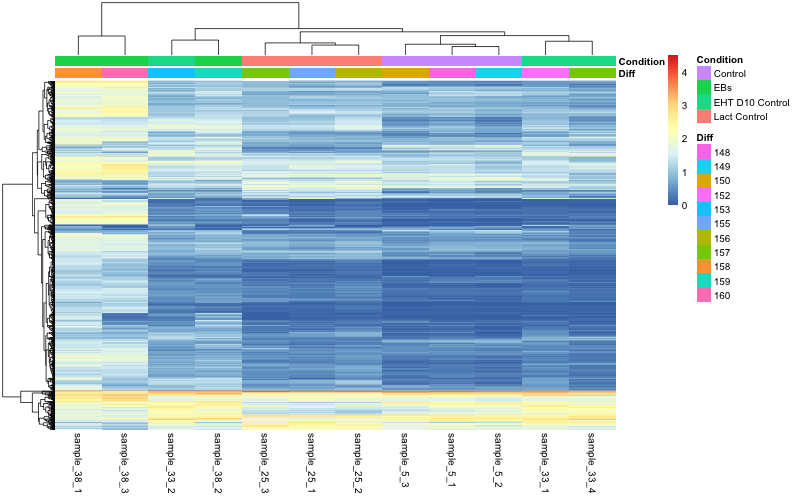

### Group 2

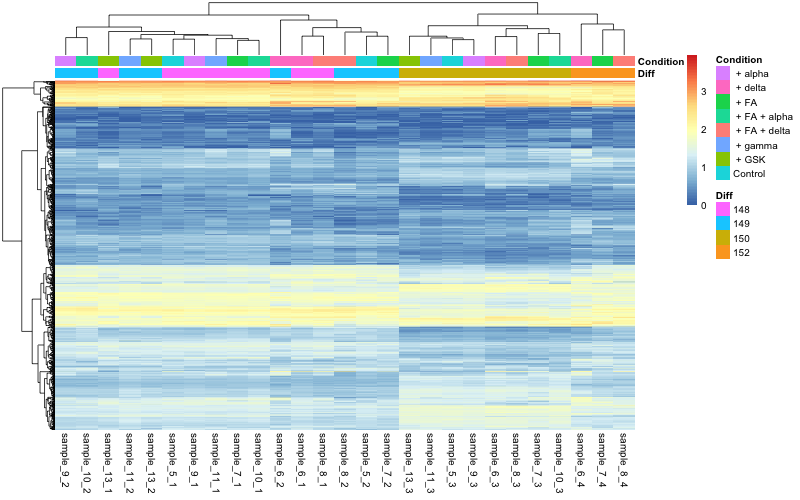

### Group 3

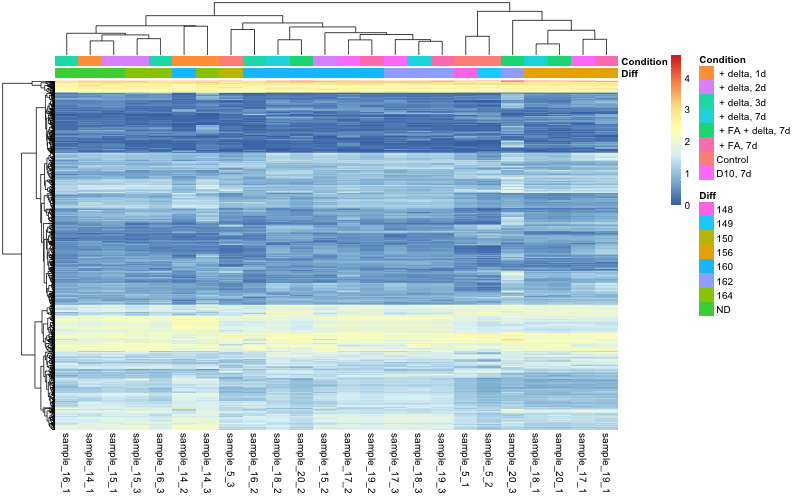

### Group 4

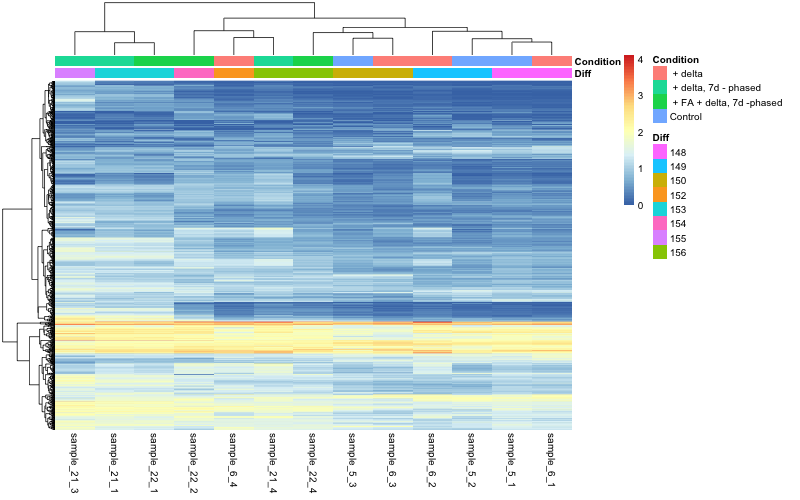

### Group 5

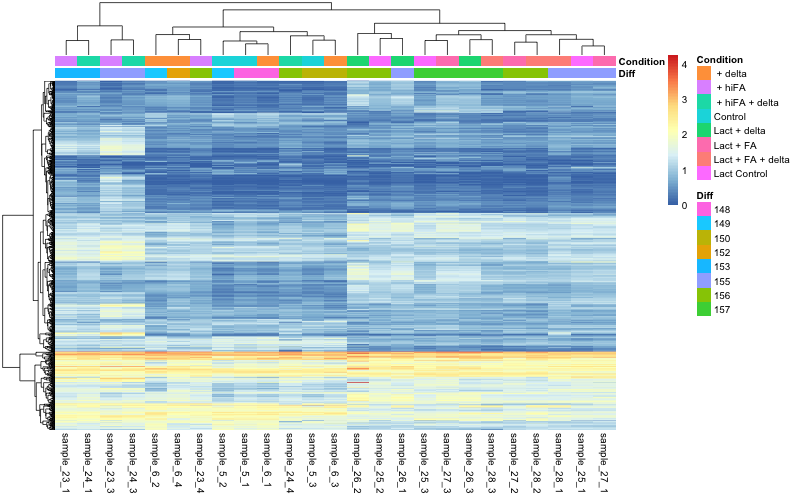

### Group 6

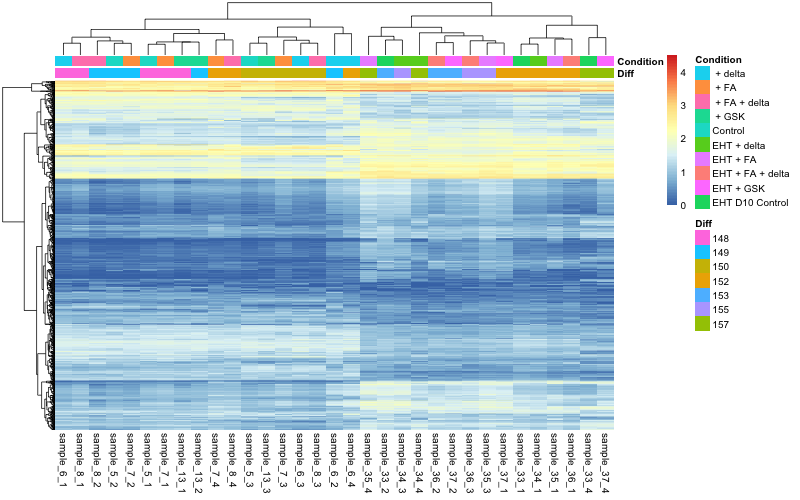

### Group 7

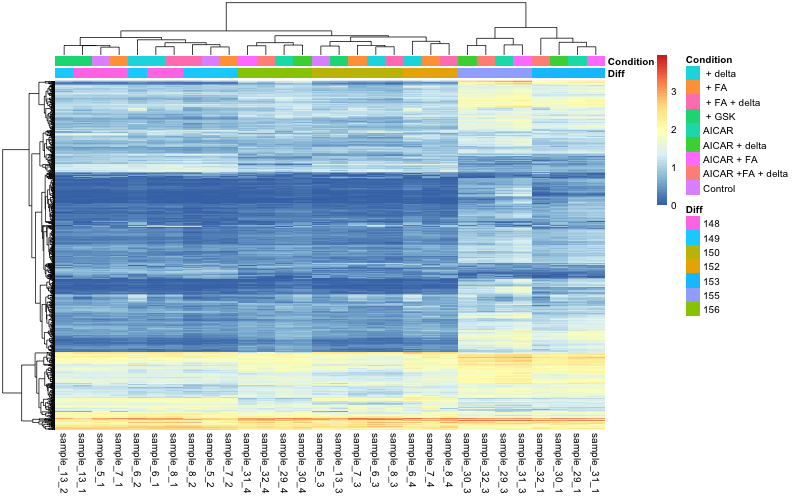

In [126]:
# Loop
for group_name, conditions in groups.items():
    plot_heatmap(group_name, conditions)